In [1]:
!pip install sbi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53672 sha256=d537166fdfbac7aee51ea4a42f14223a9e47857d22b109c1017b2c906f08a88b
  Stored in directory: /root/.cache/pip/wheels/c8/5a/0f/13956ce5f76f1688d1394146cbe7620d28d4ac05b194d1d8ed
Successfully built nflows


In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi, SNRE, SNLE
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn, classifier_nn
import numpy as np
import matplotlib.pyplot as plt

No caso mais simples possível, sem nos preocupar muito com otimização, o SBI requer 2 coisas:

- Uma distribuição prior para os parâmetros $\theta$ do simulador;
- O simulador -> $x=f(\theta)$

Além disso, podemos escolher entre 3 métodos: `SNPE`, `SNRE` e `SNLE`

In [3]:
def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

In [4]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [ ]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 73 epochs.

Vamos supor que fizemos uma observação $x$. Com isso podemos samplear a posterior $p(\theta|x)$

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

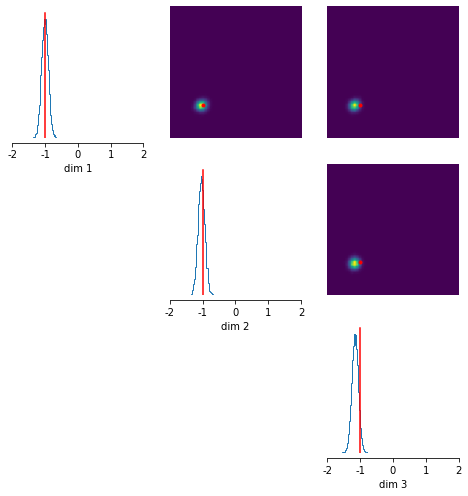

In [ ]:
true = torch.zeros(3) - 1.0
observation = simulator(true)
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(8, 8), points=true, points_colors='r', points_offdiag={"markersize": 6})

Como a inferência é amortizada, podemos samplear a posterior dada uma nova observação, sem precisar refazer o treino.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

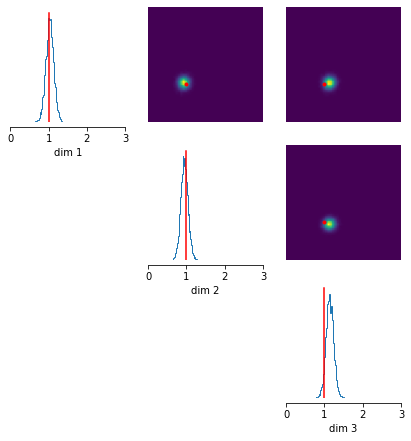

In [ ]:
true = torch.ones(3)
x_o_2 = simulator(true)
posterior_samples_1 = posterior.sample((10000,), x=x_o_2)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[0, 3], [0, 3], [0, 3]], figsize=(7, 7), points=true, points_colors='r', points_offdiag={"markersize": 6},
)

Essa interface não oferece muitas opcões de customização, apesar de ser de fácil uso. Para usarmos density estimators mais customizados, devemos explicitamente declará-los

In [28]:
density_estimator = posterior_nn(model='nsf', num_transforms=4, hidden_features=64, num_bins=4)
inference = SNPE(prior=prior, density_estimator=density_estimator)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
d_est = inference.append_simulations(theta, x).train()


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

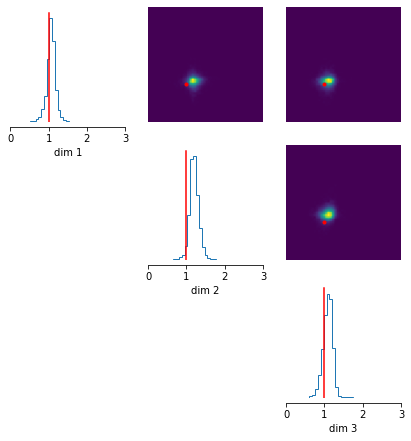

In [29]:
posterior = inference.build_posterior(d_est)
true = torch.ones(3)
x_o_2 = simulator(true)
posterior_samples_1 = posterior.sample((10000,), x=x_o_2)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[0, 3], [0, 3], [0, 3]], figsize=(7, 7), points=true, points_colors='r', points_offdiag={"markersize": 6},
)

Se estivermos interessados em somente uma observação, podemos usá-la para melhorar a estimativa da posterior. Fazendo uma inferência em várias rodadas, podemos usar samples obtidos a partir da posterior após a primeira rodada como um novo "prior".

In [11]:
simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior=prior)

In [12]:
num_rounds = 3
x_o = torch.zeros(
    3,
)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 117 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

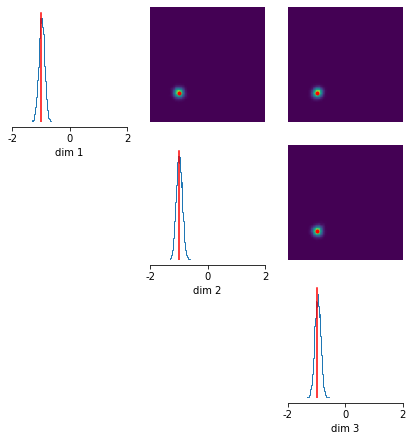

In [16]:
posterior_samples = posterior.sample((10000,), x=x_o)

_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(7, 7), points=torch.zeros(3) - 1, points_colors='r', points_offdiag={"markersize": 6},
)



Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

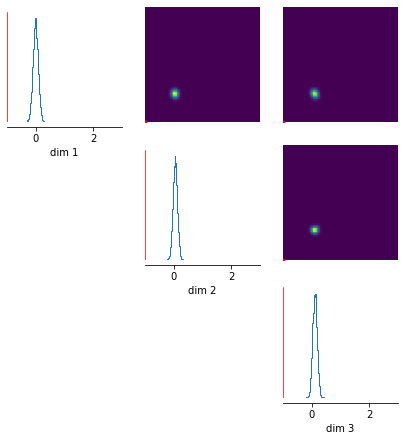

In [17]:
posterior_samples = posterior.sample((10000,), x=torch.ones(3))

_ = analysis.pairplot(
    posterior_samples, limits=[[-1, 3], [-1, 3], [-1, 3]], figsize=(7, 7), points=torch.zeros(3) - 1, points_colors='r', points_offdiag={"markersize": 6},
)



O que fazer quando o output da simulação é multi-dimensional? Podemos criar _summary statistics_ baseados no nosso conhecimento e nos dados.

Ou, podemos montar uma rede neural que aprenda a reduzir a dimensionalidade da simulação para fazer inferência: **Embedding Net**

In [26]:
class EmbeddingNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = torch.nn.MaxPool2d(kernel_size=8, stride=8)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = torch.nn.Linear(in_features=6 * 4 * 4, out_features=8)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 6 * 4 * 4)
        x = torch.nn.functional.relu(self.fc(x))
        return x

In [27]:
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

tensor([[0.2453, 0.4067, 0.0741, 0.0737, 0.1588, 0.0000, 0.5416, 0.0581]],
       grad_fn=<ReluBackward0>)

## Diagnósticos

Como saber se o resultado é consistente?

Um teste simples é rodar o simulador com parâmetros extraídos da posterior para uma determinada observação. Essa simulação deve ser similar à observação.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

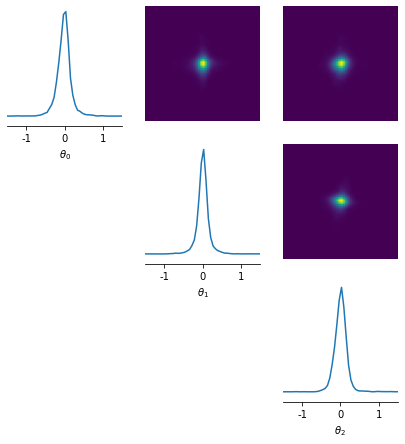

In [33]:
x_o = torch.ones(3)
posterior.set_default_x(x_o)
posterior_samples = posterior.sample((5_000,))

fig, ax = analysis.pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-1.5, 1.5]] * 3),
    upper=["kde"],
    diag=["kde"],
    figsize=(7, 7),
    labels=[rf"$\theta_{d}$" for d in range(3)],
)

In [34]:
x_pp = simulator(posterior_samples)

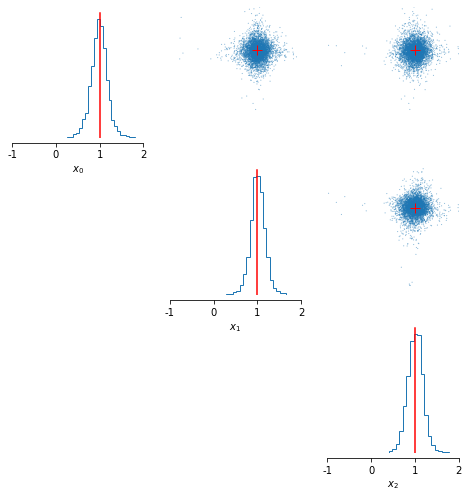

In [39]:
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o,
    limits=torch.tensor([[-1.0, 2.0]] * 3),
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=10),
    labels=[rf"$x_{d}$" for d in range(3)],
)

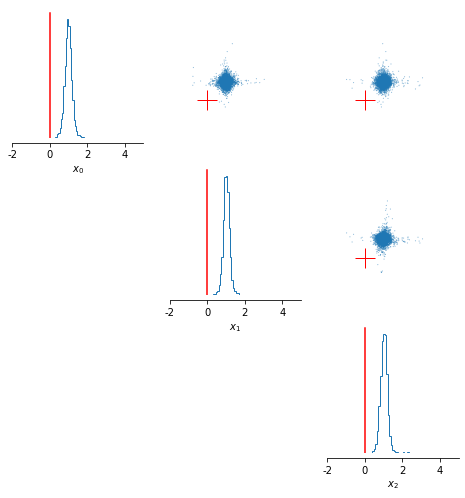

In [42]:
error_shift = -1.0 * torch.ones(3)

_ = analysis.pairplot(
    samples=x_pp,
    points=x_o + error_shift,
    limits=torch.tensor([[-2.0, 5.0]] * 3),
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{d}$" for d in range(3)],
)

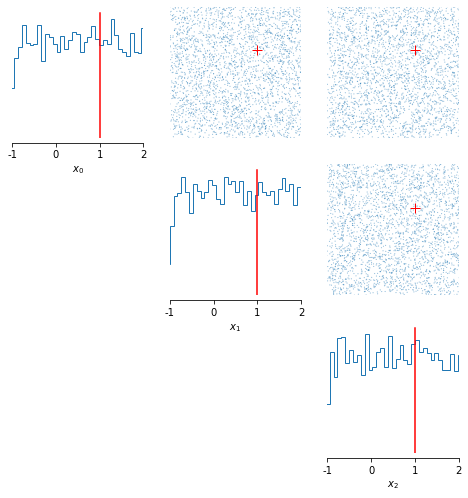

In [45]:
prior_samples = prior.sample((5000,))
x_pr = simulator(prior_samples)
_ = analysis.pairplot(
    samples=x_pr,
    points=x_o,
    limits=torch.tensor([[-1.0, 2.0]] * 3),
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=10),
    labels=[rf"$x_{d}$" for d in range(3)],
)

## Distribuições condicionais

Podemos analisar a variabilidade dos parâmetros - podem variar bastante ou são confinados a uma pequena região do espaço?

Distribuições condicionais ajudam a analisar o comportamento da posterior quando fixamos um certo número deles.

In [50]:
#@title Exemplo de posterior enviesada

class ExamplePosterior:
    """
    Class that builds a density with broad marginals and narrow conditionals.
    This is used only for the tutorial on conditional correlations.
    It has the key function that a `NeuralPosterior` object would also have. This is
    because, in the tutorial, we pretend that the posterior was obtained with SNPE --
    even though in fact it is just an `ExamplePosterior`.
    The distribution is a plane in 8-dimensional space with a bit of uniform noise
    around it. The plane is tilted, which makes the marginals broad but the conditionals
    narrow.
    """

    def __init__(self):
        # Vector that is orthogonal to the plane that has high probability.
        self.normal_vec = torch.tensor([0.9, 1.1, -1.0])
        self.noise_factor = 1.0

    def sample(self, sample_shape: torch.Size):
        """
        Return samples from the toy density.
        We first sample from a box uniform and then compute their L1-distance to a
        hyperplane in the 8D parameter space. We then accept with probability
        (1.-distance). If the distance is larger than 1.0, we never accept.
        """
        num_dim = 3
        all_samples = torch.empty(0, num_dim)
        num_accepted = 0
        while num_accepted < sample_shape[0]:
            proposed_samples = utils.BoxUniform(
                -2 * torch.ones(num_dim), 2 * torch.ones(num_dim)
            ).sample(sample_shape)
            vec_prior_samples = proposed_samples * self.normal_vec
            dist_to_zero = torch.abs(torch.sum(vec_prior_samples, dim=1))
            accept_or_not = (
                self.noise_factor * torch.rand(dist_to_zero.shape) > dist_to_zero
            )
            accepted_samples = proposed_samples[accept_or_not]

            num_accepted += accepted_samples.shape[0]
            all_samples = torch.cat((all_samples, accepted_samples), dim=0)
        return all_samples

    def log_prob(self, theta: torch.Tensor):
        """
        Compute the unnormalized log-probability of the toy density.
        This is done by computing the acceptance probability (see `.sample()` method.
        Because the samples were proposed by a box uniform distribution, the acceptance
        probability is proportional to the joint density.
        """
        vec_prior_samples = theta * self.normal_vec
        dist_to_zero = torch.abs(torch.sum(vec_prior_samples, dim=1))
        acceptance_prob = torch.max(
            torch.zeros(dist_to_zero.shape), self.noise_factor - dist_to_zero
        )
        return torch.log(acceptance_prob)

    def set_default_x(self, x: torch.Tensor):
        """
        Does not do anything. This function only exists because we pretend that this
        class is a `NeuralPosterior` in the tutorial. Calling `set_default_x()` is a
        required step when analysing conditional correlations.
        """
        pass

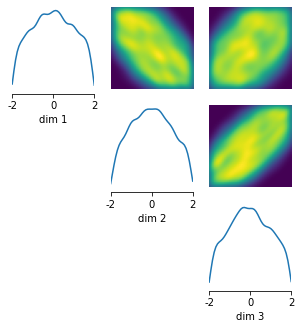

In [52]:
posterior = ExamplePosterior()
x_o = torch.ones(1, 20)  # simulator output was 20-dimensional
posterior.set_default_x(x_o)
posterior_samples = posterior.sample((5000,))

fig, ax = analysis.pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    upper=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)

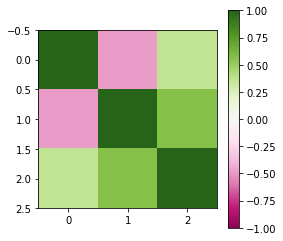

In [53]:
corr_matrix_marginal = np.corrcoef(posterior_samples.T)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap="PiYG")
_ = fig.colorbar(im)

In [54]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML, Image

rc("animation", html="html5")

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))


def init():
    (line,) = ax.plot([], [], lw=2)
    line.set_data([], [])
    return (line,)


def animate(angle):
    num_samples_vis = 1000
    line = ax.scatter(
        posterior_samples[:num_samples_vis, 0],
        posterior_samples[:num_samples_vis, 1],
        posterior_samples[:num_samples_vis, 2],
        zdir="z",
        s=15,
        c="#2171b5",
        depthshade=False,
    )
    ax.view_init(20, angle)
    return (line,)


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=range(0, 360, 5), interval=150, blit=True
)

plt.close()

In [55]:
HTML(anim.to_html5_video())

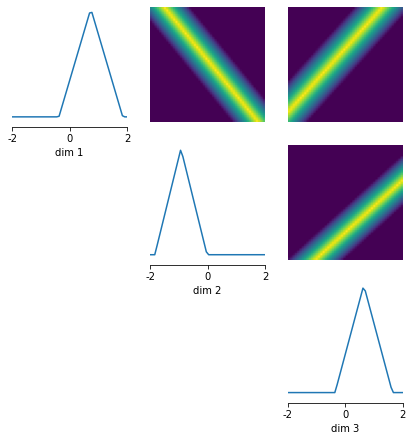

In [58]:
condition = posterior.sample((1,))

_ = analysis.conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    figsize=(7, 7),
)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


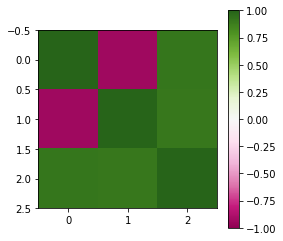

In [59]:
cond_coeff_mat = analysis.conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap="PiYG")
_ = fig.colorbar(im)

## Um exemplo completo

Simular a órbita de um planeta pertindo do período e da excentricidade, retornando uma série de ângulos (em relação a um dos focos e ao periélio)

In [110]:
def make_kepler_orbit(theta):
    """Período em anos"""  
    e = theta[0]
    p_orb = theta[1]
    nStep = 100
    tRange = np.linspace(0,p_orb,nStep)
    
    theta = []
    for time in tRange:
        nHalfPorb = int(2*(time-1)/p_orb)
        PsiDiff = 1
        M = 2*np.pi*time/p_orb
        PsiOld = M
        theta0old = 180.0
        while PsiDiff > 1e-10:
        #print PsiDiff, PsiOld, e*math.sin(PsiOld)
            PsiNew = M + e*np.sin(PsiOld)
            PsiDiff = PsiNew-PsiOld
            PsiOld = PsiNew
        theta0 = 2*np.arctan(((1+e)/(1-e))**(0.5)*np.tan(PsiOld/2.))
        theta.append(theta0)        
    return np.array(theta)

def orbit(sep,e,true_anomaly): 
    ##############################################
    # Units: separation [same as units supplied] #
    ##############################################
    
    # define the shape equation
    rorbit = sep*(1 - e**2)/(1 + e*np.cos(true_anomaly))
    xorbit = rorbit*np.cos(true_anomaly)
    yorbit = rorbit*np.sin(true_anomaly)
     
    
    return xorbit,yorbit

def keplerIII_period_to_separation(p_orb):
    #########################################################
    # Units: orbital period [yr], separation [au]           #
    #########################################################
    sep_cubed = p_orb**2
    sep = sep_cubed**(1./3.)
    
    return sep

In [76]:
anomaly = make_kepler_orbit([0.6, 1.5])
xorb, yorb = orbit(keplerIII_period_to_separation(1.5), 0.6, anomaly)

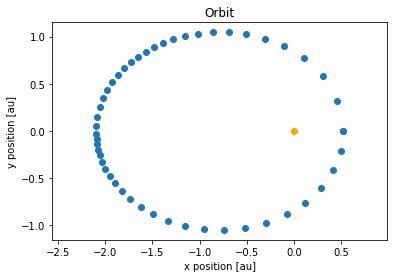

In [77]:
plt.title('Orbit')
# The Sun is located at the origin.
plt.scatter(0,0, color='orange')
plt.scatter(xorb,yorb)
plt.axis('equal')
plt.xlabel('x position [au]')
plt.ylabel('y position [au]')
plt.show()

In [111]:
prior = utils.BoxUniform(low=torch.tensor([0.01, 0.3]), high=torch.tensor([0.8, 20]))

In [112]:
simulator, prior = prepare_for_sbi(make_kepler_orbit, prior=prior)

In [113]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

In [134]:
density_estimator = posterior_nn(model='nsf', num_transforms=6, hidden_features=64, num_blocks=4)
inference = SNPE(prior=prior, density_estimator=density_estimator)
d_est = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 67 epochs.

In [135]:
posterior = inference.build_posterior(d_est)

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

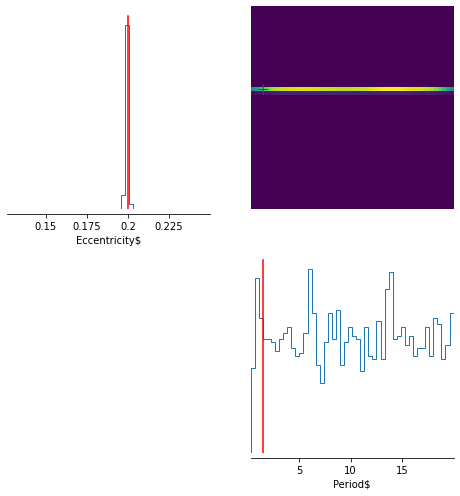

In [136]:
true = [0.2, 1.5]
obs = make_kepler_orbit(true)
samples_obs = posterior.sample((2000,), x=obs)
names = ['Eccentricity', 'Period']
_ = analysis.pairplot(
    samples=samples_obs,
    points=torch.tensor(true),
    #limits=torch.tensor([[-1.0, 2.0]] * 3),
    points_colors="red",
    figsize=(8, 8),
    upper="kde",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=10),
    labels=[f"{d}$" for d in names],
)

/usr/local/lib/python3.8/dist-packages/sbi/analysis/plot.py:821: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim((limits[col][0], limits[col][1]))
/usr/local/lib/python3.8/dist-packages/sbi/analysis/plot.py:823: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim((limits[row][0], limits[row][1]))
/usr/local/lib/python3.8/dist-packages/sbi/analysis/plot.py:823: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim((limits[row][0], limits[row][1]))


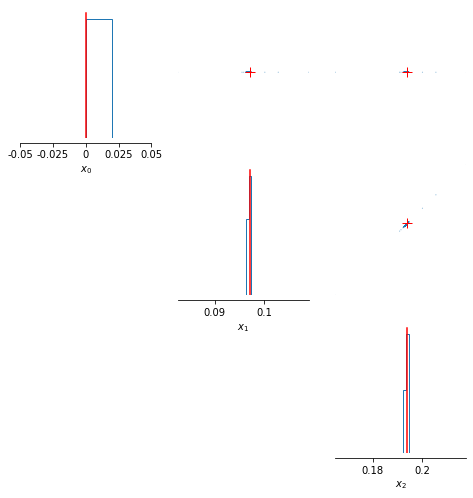

In [137]:
x_pp = simulator(samples_obs)
_ = analysis.pairplot(
    samples=x_pp[:,:3],
    points=obs[:3],
    #limits=torch.tensor([[-1.0, 2.0]] * 3),
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=10),
    labels=[rf"$x_{d}$" for d in range(3)],
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

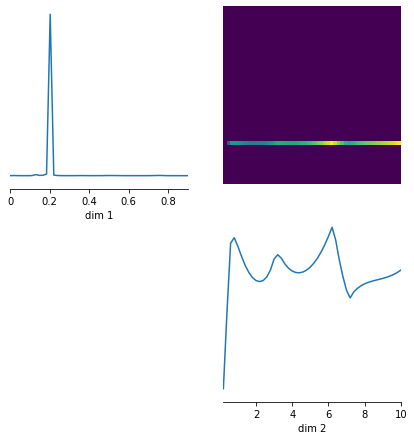

In [162]:
posterior.set_default_x(obs)
condition = posterior.sample((1,))
_ = analysis.conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[0,0.9], [0.2, 10]]),
    figsize=(7, 7),
)

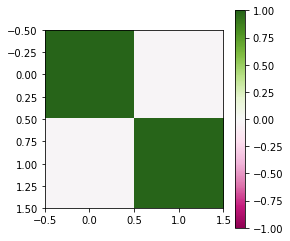

In [163]:
cond_coeff_mat = analysis.conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[0,0.9], [0.2, 10]]),
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap="PiYG")
_ = fig.colorbar(im)